In [11]:
import torch
import tiktoken
from ch_4.build_gpt import GPTModel, generate_text_simple
from ch_2.dataloader import create_dataloader_v1

'''
1.1：使用 GPT 生成文本
'''
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,  # 我们将上下文长度从1024个token缩短到256个token
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,  # 将 dropout 设置为 0 是一种常见的做法
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()


# Utility functions for text to token ID conversion
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

'''
1.2：计算文本生成损失
'''
inputs = torch.tensor([[16833, 3626, 6100],  # ["every effort moves",
                       [40, 1107, 588]])  # "I really like"]
# Matching these inputs, the `targets` contain the token IDs we aim for the model to produce:
targets = torch.tensor([[3626, 6100, 345],  # [" effort moves you",
                        [107, 588, 11311]])  # " really like chocolate"]

with torch.no_grad():  # 禁用梯度跟踪，因为我们尚未进行训练
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)  # Probability of each token in vocabulary
print(probas.shape)

# 通过对概率得分应用 argmax 函数，可以得到对应的 token ID
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

# 将token ID 转换回文本
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")
# When we decode these tokens, we find that these output tokens are quite different from the target tokens we want the model to generate:
# Targets batch 1: effort moves you
# Outputs batch 1: Armed heNetflix

# 对于这两个输入文本，我们可以通过以下代码打印与目标 token 对应的初始 softmax 概率得分
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

'''
如何最大化目标 token 的 softmax 概率值？整体思路是通过更新模型权重，使模型在生成目标 token 时输出更高的概率值。
通过反向传播：需要一个损失函数，该函数用于计算模型预测输出与实际目标输出之间的差异（此处指与目标 token ID 对应的概率）。这个损失函数用于衡量模型预测与目标值的偏差程度

在机器学习，特别是 PyTorch 等框架中，cross_entropy 函数用于计算离散输出的损失，与模型生成的 token 概率下的目标 token 的负平均对数概率类似
'''
# 对这些目标token的概率得分取对数
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

# 接下来，通过计算平均值将这些对数概率合并为一个评分
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

# 在深度学习中，常见做法并不是直接将平均对数概率推向 0，而是通过将负平均对数概率降低至 0 来实现
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

# 在 PyTorch 中，cross_entropy 函数能够自动完成所有上面的步骤计算损失值
# 在 PyTorch 中使用交叉熵损失函数时，我们需要将这些张量展平，以便在批量维度上进行合并
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

'''
1.3：计算训练集和验证集的损失
'''
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

# 首先定义一个 train_ratio，用于将 90% 的数据用于训练，剩余 10% 用于在训练期间进行模型评估
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# 复用第 2 章中的 create_dataloader_v1 代码来创建相应的数据加载器（训练数据集和测试数据集）
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)


# 输入数据（x）和目标数据（y）的形状相同（即批次大小 × 每批的 token 数量），因为目标数据是将输入数据整体向后偏移一个位置得到的
# print("Train loader:")
# for x, y in train_loader:
#     print(x.shape, y.shape)
#
# print("\nValidation loader:")
# for x, y in val_loader:
#     print(x.shape, y.shape)


# 实现一个工具函数calc_loss_batch，用于计算由训练和验证加载器返回的批量数据的交叉熵损失
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)  # 将数据传输到指定设备（如 GPU），使数据能够在 GPU 上处理。
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss


# calc_loss_loader 将用于计算指定数据加载器中的指定数据批次的损失
# Function to compute the training and validation loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)  # A
    else:
        num_batches = min(num_batches, len(data_loader))  # B
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()  # C
        else:
            break
    return total_loss / num_batches  # D


# A 如果没有指定批次数，将自动遍历所有批次
# B 若批次数超过数据加载器的总批次数，则减少批次数使其与数据加载器的批次数相匹配
# C 每个批次的损失求和
# D 对所有批次的损失取平均值

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # A
model.to(device)
with torch.no_grad():  # B
    train_loss = calc_loss_loader(train_loader, model, device)  # C
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

# A 如果你的设备配备了支持 CUDA 的 GPU，LLM 将自动在 GPU 上进行训练，无需更改代码
# B 因为当前不在训练，为提高效率，关闭梯度跟踪
# C 通过 device 设置确保数据与 LLM 模型加载到同一设备上

'''
2：预训练LLM
'''
# the main function for pretraining LLMs
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []  # A
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):  # B
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # C
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # D
            optimizer.step()  # E
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:  # F
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"------ Ep {epoch + 1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(  # G
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen


# A 初始化用于记录损失和已处理 token 数量的列表
# B 开始主训练循环
# C 重置上一批次的损失梯度
# D 计算损失梯度
# E 使用损失梯度更新模型权重
# F 可选的评估步骤
# G 每个 epoch 结束后打印示例文本

# evaluate_model 函数会在训练集和验证集上计算损失，同时确保模型处于评估模式，并在计算损失时禁用梯度跟踪和 dropout
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  # A
    with torch.no_grad():  # B
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


# A 评估阶段禁用 dropout，以确保结果稳定、可复现
# B 禁用梯度跟踪，减少计算开销

# generate_and_print_sample text函数则通过生成的实际文本示例，帮助我们在训练过程中判断模型的能力
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


'''
实例化一个GPT model，开始训练
'''
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)  # A
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren
torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix
Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([3.9108e-05, 5.6776e-05, 4.7559e-06])
tensor([ -9.5042, -10.3796, -11.3677, -10.1492,  -9.7764, -12.2561])
tensor(-10.5722)
tensor(10.5722)
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
tensor(10.5722)
Characters: 20479
Tokens: 5145
Training loss: 10.987583584255642
Validation loss: 10.981106758117676
------ Ep 1 (Step 000000): Train loss 9.830, Val loss 9.927
------ Ep 1 (Step 000005): Train loss 8.133, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
------ Ep 2 (Step 000010): Train loss 6.770, Val loss 7.048
------ Ep 2 (Step 000015): Train loss 6.497, 

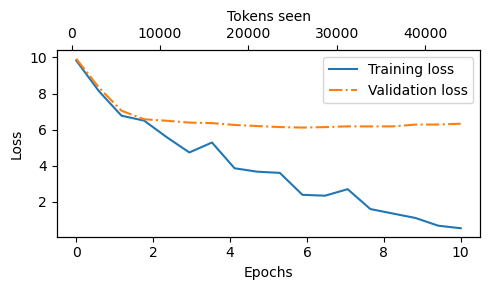

In [12]:
# 先创建一个简单的图表，将训练集和验证集损失并排展示
import matplotlib.pyplot as plt


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny()  # A
    ax2.plot(tokens_seen, train_losses, alpha=0)  # B
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# A 创建与 y 轴共用的第二个 x 轴
# B 用于对齐刻度的隐藏图形

In [13]:


'''
在一个较小的数据集上进行多轮训练，容易产生过拟合的现象的原因：
1. 模型容量与数据集大小的匹配问题
2. 多轮训练导致对数据集细节的过度学习
3. 数据集的多样性不足
4. 过拟合与模型泛化能力的矛盾
'''

'''
3: 通过解码策略控制生成结果的随机性
'''
# LLM 的文本生成策略，以减少训练数据的记忆倾向，提升 LLM 生成文本的原创性
model.to("cpu")
model.eval()

'''
3.1：Temperature scaling（一种在生成下一个词时加入概率选择的技术）

为了实现概率采样过程，现在可以用 PyTorch 中的 multinomial 函数代替 argmax
'''
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [14]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

# 假设给 LLM 一个初始上下文‘every effort moves you’，并生成下一个 token 的 logits 分数
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [15]:
# 为了实现概率采样过程，现在可以用 PyTorch 中的 multinomial 函数代替 argmax
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

# “forward” 依然是最有可能的 token，因此大多数情况下会被 multinomial 选中，但并不是每次都选中
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

toward
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


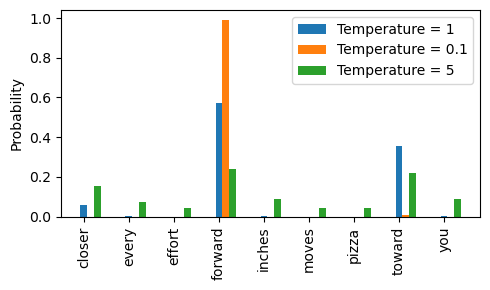

In [16]:
# 可以通过一种称为temperature scaling的方法进一步控制分布和选择过程，所谓temperature scaling，其实就是将 logits 除以一个大于 0 的数
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)
#Temperatures greater than 1 result in more uniformly distributed token probabilities, and Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions. Let's illustrate this by plotting the original probabilities alongside probabilities scaled with different temperature values:
temperatures = [1, 0.1, 5]             #A
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

#A 原始、较低和较高置信度

In [17]:
'''
3.2：Top-k 采样

temperature scaling 有时会导致生成语法不正确或完全不合逻辑的内容
'''
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

# 应用 PyTorch 的 where 函数，将非 top-3 的 token 的 logit 值设为负无穷大（-inf）
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],   #A
    input=torch.tensor(float('-inf')),              #B
    other=next_token_logits                         #C
)
print(new_logits)

#A 识别出小于 top 3 最小值的 logits
#B 将这些较小的 logits 赋值为负无穷大
#C 保留所有其他 token 的原始 logits

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [18]:
# 应用 softmax 函数将其转化为下一词的概率分布
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

'''
3.3：对文本生成函数进行调整
'''
# A modified text generation function with more diversity
def generate(model, idx, max_new_tokens, context_size,
             temperature=1.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):                             #A
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:                                   #B
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        if temperature > 0.0:                                       #C
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:                                                       #D
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:                                      #E
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


#A For循环与之前相同：获取logits，仅关注最后的时间步
#B 在新步骤中，通过top-k采样过滤logits
#C 在新步骤中应用temperature scaling
#D 在未使用temperature scaling时，执行贪婪的下一个token选择
#E 如果遇到序列结束token且指定了eos_id，则提前停止生成

torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])
Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough


In [25]:
'''
4: 在 PyTorch 中加载和保存模型权重
'''
# 推荐的做法是保存模型的 state_dict（状态字典），这是一个字典，用于将模型的每一层映射到其对应的参数上，可以通过 torch.save 函数来实现
torch.save(model.state_dict(), "model.pth")

# 使用 state_dict 保存模型权重后，可以将权重加载到新的 GPTModel 模型实例中
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [24]:
# AdamW 等自适应优化器会为每个模型参数存储额外信息。AdamW 使用历史数据动态调整每个模型参数的学习率。
# 没有这些信息时，优化器会重置，模型可能无法有效学习，甚至无法正确收敛，进而失去生成连贯文本的能力。可以使用 torch.save 保存模型和优化器的状态
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [21]:
'''
5: 从 OpenAI 加载预训练权重
'''
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x14d15ec4d90>)

In [3]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [4]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 79.1kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 7.56MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 92.3kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [17:04<00:00, 486kiB/s]    
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 5.21MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 19.5MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 6.25MiB/s]


In [7]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [23]:
# 在将 GPT-2 模型的权重加载到 Python 后，我们还需要将这些权重从 settings 和 params 字典转移到 GPTModel 实例中
#  create a dictionary that lists the differences between the different GPT model sizes, as explained in Figure 5.17:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
# Suppose we are interested in loading the smallest model, "gpt2-small (124M)". We can use the corresponding settings from the model_configs table able to update our full-length GPT_CONFIG_124M we defined and used earlier throughout the chapter as follows:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

# 之前设置的 token 长度是 256，但 OpenAI 的原始 GPT-2 模型使用的是 1,024 的 token 长度
NEW_CONFIG.update({"context_length": 1024})

NEW_CONFIG.update({"qkv_bias": True})
# We can now use the updated NEW_CONFIG dictionary to initialize a new GPTModel instance:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()


# 定义一个简单的assign工具函数，用于检查两个张量或数组（左侧和右侧）的维度或形状是否一致，并将右侧张量作为可训练的 PyTorch 参数返回
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

# Loading OpenAI weights into our GPT model code
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])               #A
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):                                       #B
        q_w, k_w, v_w = np.split(                                                #C
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])                   #D


#A 将模型的位置嵌入和token 嵌入的权重设置为 params 中指定的值
#B 遍历模型中的每个 Transformer 模块
#C 使用 np.split 函数将注意力和偏置权重分为三等份，分别用于查询、键和值组件
#D OpenAI 的原始 GPT-2 模型在输出层中复用了 token 嵌入的权重，以减少参数总量，这一概念称为权重共享

load_weights_into_gpt(gpt, params)
gpt.to(device)

torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the
